In [2]:
# Import des libraries

from bigml.api import BigML
import pandas
from pandas import read_csv
import matplotlib

In [15]:
# Modification du fichier Train de Kaggle

df = read_csv('https://oml-data.s3.amazonaws.com/kaggle-give-me-credit-train.csv', index_col=0)
df = df.fillna(0)
df['MonthlyPerPerson'] = df['MonthlyIncome'] / ( df['NumberOfDependents'] + 1 )
df.loc[df.age > 80, 'isOld'] = '1' 
df.loc[df.age <= 80, 'isOld'] = '0' 
df.to_csv('train_full.csv')

In [3]:
# Connexion au projet via l'API de BIG ML

api = BigML('MAXIMEFAVOT', '69757fb108f0bd7a8678e0b66e3de66ae6478c81', project='project/5d9e081659f5c320e1000597')

In [17]:
# Creation des sources sur BigML

source_train = api.create_source('train_full.csv')
trainfull_dataset = api.create_dataset(source_train)

In [18]:
# Création du split 80/20

train_dataset = api.create_dataset(
    trainfull_dataset, {"name": "Training_split", "sample_rate": 0.8, "seed": "my seed"})
test_dataset = api.create_dataset(
    trainfull_dataset, {"name": "Test_split", "sample_rate": 0.8, "seed": "my seed", "out_of_bag": True})

In [19]:
# Création du modele Ensemble

ensemble = api.create_ensemble(train_dataset, {"name": "ensemble", "objective_field": "SeriousDlqin2yrs"})


In [69]:
# Summary Report du Modele

model = api.get_ensemble("ensemble/5db702215299631c8200bc4a")

importance = model['object']['importance']
# importance['000003']

importances_named = dict()
for column, importance in importance.items():
    column_name = model['object']['ensemble']['fields'][column]['name']
    
    
    importances_named[column_name] = [importance*100]

df = pandas.DataFrame.from_dict(data=importances_named, orient='index')
df = df.sort_values(0, ascending=False)
df

,0
RevolvingUtilizationOfUnsecuredLines,20.802
NumberOfTimes90DaysLate,15.601
NumberOfTime30-59DaysPastDueNotWorse,13.113
NumberOfTime60-89DaysPastDueNotWorse,9.870
age,9.635
NumberOfOpenCreditLinesAndLoans,9.589
NumberRealEstateLoansOrLines,5.318
MonthlyIncome,4.516
DebtRatio,3.906
field1,3.461


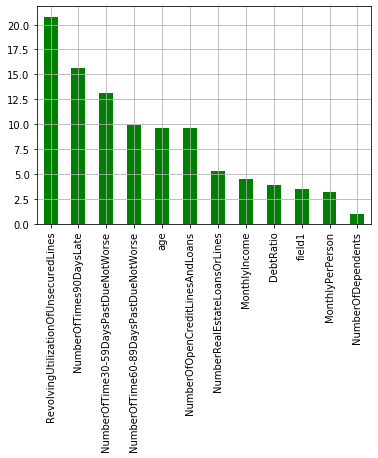

In [73]:
# Affichage sous forme d'histogramme

df.plot(kind='bar', color= 'green', legend=False, grid=True)

In [6]:
# Batch Prediction et Download

batch_prediction = api.create_batch_prediction(ensemble, test_dataset,{"all_fields": True, "probabilities": True})

NameError: name 'ensemble' is not defined

In [22]:
api.download_batch_prediction(batch_prediction, filename='Prediction2.csv')

'Prediction2.csv'

In [23]:
evaluation = api.create_evaluation(ensemble, test_dataset)
api.ok(evaluation)
api.pprint(evaluation['object']['result']['model']['accuracy'])
api.pprint(evaluation['object']['result']['model']['average_area_under_roc_curve'])
api.pprint(evaluation['object']['result']['model']['confusion_matrix'])

0.93563
0.85577
[[27717, 268], [1663, 352]]
